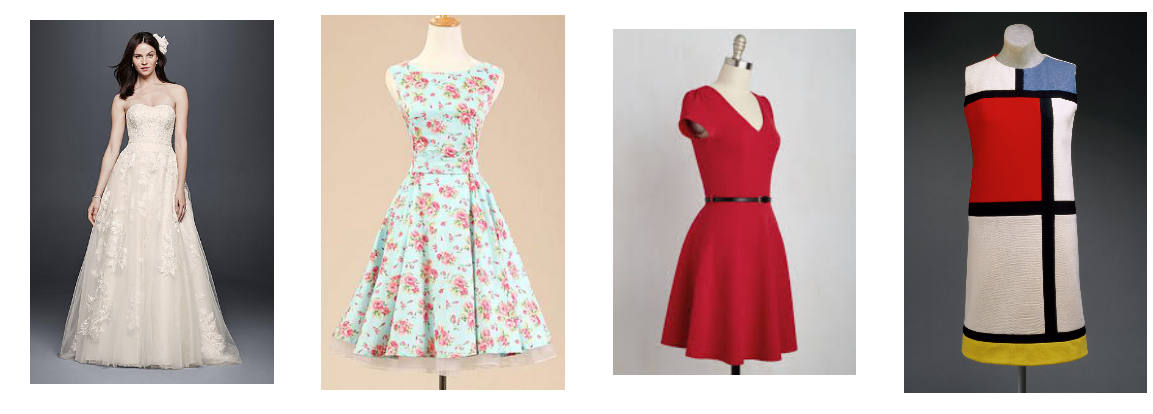

In [4]:
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from PIL import Image, ImageDraw

images = glob('sample/basic/*')
imgs = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in images]

def imshow(img, **kwargs):
    plt.imshow(img, **kwargs)
    plt.axis('off')

def imshowall(imgs, cols=4, **kwargs):
    plt.figure(figsize=(20,60))

    for idx in range(len(imgs)):
        plt.subplot(len(imgs)/cols, cols, idx+1)
        plt.imshow(imgs[idx], **kwargs)
        plt.axis('off')

def colshow(colors, swatchsize = 120):
    numcolors = len(colors)
    pal = Image.new('RGB', (swatchsize*numcolors, swatchsize))
    draw = ImageDraw.Draw(pal)

    posx = 0
    for col in colors:
        draw.rectangle([posx, 0, posx+swatchsize, swatchsize], fill=col)
        posx = posx + swatchsize

    del draw
    imshow(pal)
    
def colshowall(palettes, swatchsize = 120):
    pals = []
    for colors in palettes:
        colors = colors[:5]
        numcolors = len(colors)
        pal = Image.new('RGB', (swatchsize*numcolors, swatchsize))
        draw = ImageDraw.Draw(pal)

        posx = 0
        for col in colors[:5]:
            draw.rectangle([posx, 0, posx+swatchsize, swatchsize], fill=col[1])
            draw.text((posx,0), ",".join([col[0], col[2]]))
            posx = posx + swatchsize

        del draw
        pals.append(pal)
    
    imshowall(pals, cols=1)
        
imshowall(imgs)

# Zollinger
https://gist.github.com/zollinger/1722663

In [ ]:
def get_colors(img, numcolors=5):

    #image = image.resize((resize, resize))
    result = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)
    result.putalpha(0)
    return result.getcolors()

In [ ]:
image = Image.open(images[0])

%time colors = get_colors(image)

In [ ]:
colors = get_colors(Image.open(images[0]))
colshow([col[:3] for count, col in colors])

In [ ]:
colors = get_colors(Image.open(images[1]))
colshow([col[:3] for count, col in colors])

In [ ]:
colors = get_colors(Image.open(images[2]))
colshow([col[:3] for count, col in colors])

In [ ]:
colors = get_colors(Image.open(images[3]))
colshow([col[:3] for count, col in colors])

# pixelogik
https://github.com/pixelogik/ColorCube

In [ ]:
from ColorCube import ColorCube

cc = ColorCube()
image = Image.open(images[0])

%time colors = cc.get_colors(image)

In [ ]:
colors = cc.get_colors(Image.open(images[0]))
colors = [tuple(color) for color in colors[:5]]
colshow(colors)

In [ ]:
colors = cc.get_colors(Image.open(images[1]))
colors = [tuple(color) for color in colors[:5]]
colshow(colors)

# ColorThief
https://github.com/fengsp/color-thief-py

In [ ]:
from colorthief import ColorThief
color_thief = ColorThief(images[0])
# get the dominant color
%time colors = color_thief.get_color(quality=10)

# OpenCV pixel count

In [59]:
import cv2
import numpy as np

class Palette(object):
    def hex_to_rgb(self, value):
        value = value.lstrip('#').lower()
        lv = len(value)
        return [int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)]

    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % tuple(rgb)

    def closest_node(self, node):
        deltas = self.labs - node
        dist_2 = np.einsum('ij,ij->i', deltas, deltas)
        return np.argmin(dist_2)
    
    def rgb_to_lab(self, rgb):
        pix = np.array([[rgb]])
        return cv2.cvtColor(pix, cv2.COLOR_RGB2LAB)[0][0]
        
    def dominant(self, img, mask):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        Z = img[np.where(mask==1)]
        return np.apply_along_axis(self.closest_node, 1, Z)
    
    def rgb_to_closest_name(self, rgb):
        idx = self.closest_node(self.rgb_to_lab(rgb))
        return self.names[idx]
            
    def __init__(self, f):
        self.names = []
        self.labs = []
        with open(f) as fr:
            for line in fr:
                line = line.lower().split(',')
                name = line[0].strip()
                val = line[1].strip()
                self.names.append(name)
                rgb = np.uint8(np.array(self.hex_to_rgb(val)))
                lab = self.rgb_to_lab(rgb)
                self.labs.append(lab)
                
palette = Palette('palette.csv')

# Back to Zollinger

In [138]:
import cv2
import numpy as np
from glob import glob
from utils import background_mask, resize

images = glob('sample/medium/*')
imgs = [cv2.imread(img, cv2.IMREAD_UNCHANGED) for img in sorted(images)]
imgs = [resize(img, max_height=300., max_width=300) for img in imgs]
masks = [background_mask(img) for img in imgs]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

In [ ]:
palettes = []
pimgs = []
for img, mask in zip(imgs, masks):
    img = Image.fromarray(img).convert('P', palette=Image.ADAPTIVE, colors=10)
    mask = Image.fromarray(mask).convert('L')
    img.putalpha(mask)
    colors = img.getcolors()
    colors = [(count, color[:3]) for count, color in colors if color[3]>0]
    colors.sort(key=lambda tup: tup[0], reverse=True)
    tot = sum([count for count, color in colors])
    colors = [(100*float(count)/tot, color) for count, color in colors]
    colors = [("%0.2f"%per, color, palette.rgb_to_closest_name(np.uint8(color))) for per, color in colors]
    palettes.append(colors)

In [ ]:
pimgs = []
for img, mask in zip(imgs, masks):
    img = Image.fromarray(img).convert('P', palette=Image.ADAPTIVE, colors=10)
    mask = Image.fromarray(mask).convert('L')
    img.putalpha(mask)
    pimgs.append(img)

imshowall(pimgs)

In [ ]:
palettes = []
pimgs = []
for psize in [10, 50, 100,  150, 200]:
    img = imgs[15]
    mask = masks[15]
    img = Image.fromarray(img).convert('P', palette=Image.ADAPTIVE, colors=psize)
    mask = Image.fromarray(mask).convert('L')
    img.putalpha(mask)
    colors = img.getcolors()
    colors = [(count, color[:3]) for count, color in colors if color[3]>0]
    colors.sort(key=lambda tup: tup[0], reverse=True)
    tot = sum([count for count, color in colors])
    colors = [(100*float(count)/tot, color) for count, color in colors]
    colors = [("%0.2f"%per, color, str(color)) for per, color in colors]
    palettes.append(colors)

# OpenCV's kmeans
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html

30.89


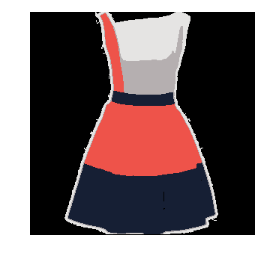

In [11]:
import numpy as np
import cv2
from utils import background_mask

img = cv2.cvtColor(cv2.imread('sample/medium/16.jpeg'), cv2.COLOR_BGR2RGB)
mask = background_mask(img)
img = cv2.GaussianBlur(img, (5,5), 0)
img = cv2.bitwise_and(img, img, mask=mask)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv2.kmeans(Z, K, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
print("%.2f"%(ret/1000000))

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

imshow(res2)

# pyimagesearch
http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/

In [35]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

0.122032801549
0.862508504898
0.0154586935525


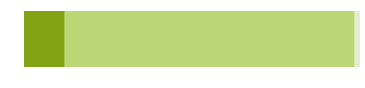

In [58]:
from sklearn.cluster import KMeans

img = cv2.imread('sample/medium/26.png', cv2.IMREAD_UNCHANGED)
mask = background_mask(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.GaussianBlur(img, (5,5), 0)
#img = cv2.bitwise_and(img, img, mask=mask)
#Z = img.reshape((-1,3))
Z = img[np.where(mask>0)]

# convert to np.float32
Z = np.float32(Z)

clt = KMeans(n_clusters = 3)
clt.fit(Z)

hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
 
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

# Final Straw - Back to color mapping

In [146]:
import cv2
import numpy as np

class Palette(object):
    tolerance = 30
    
    def hex_to_rgb(self, value):
        value = value.lstrip('#').lower()
        lv = len(value)
        return [int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)]

    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % tuple(rgb)
    
    def rgb_to_closest_name(self, rgb):
        idx = self.closest_node(self.rgb_to_lab(rgb))
        return self.names[idx]
       
    def build_boundaries(self):
        self.boundaries = []
        for rgb in self.rgbs:
            mins = np.array([max(0, rgb[0]-self.tolerance), 
                   max(0, rgb[1]-self.tolerance),
                   max(0, rgb[2]-self.tolerance)], dtype=np.uint8)
            maxs = np.array([min(255, rgb[0]+self.tolerance), 
                   min(255, rgb[1]+self.tolerance),
                   min(255, rgb[2]+self.tolerance)], dtype=np.uint8)
            self.boundaries.append((mins, maxs))
            
    
    def __init__(self, f):
        self.names = []
        self.rgbs = []
        with open(f) as fr:
            for line in fr:
                line = line.lower().split(',')
                name = line[0].strip()
                val = line[1].strip()
                self.names.append(name)
                rgb = np.uint8(np.array(self.hex_to_rgb(val)))
                self.rgbs.append(rgb)
        self.build_boundaries()
                
palette = Palette('palette.csv')

In [124]:
img = cv2.imread('sample/medium/26.png', cv2.IMREAD_UNCHANGED)
mask = background_mask(img)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
img = cv2.GaussianBlur(img, (5,5), 0)
#img = cv2.bitwise_and(img, img, mask=mask)
#Z = img.reshape((-1,3))
#Z = img[np.where(mask>0)]

[(24.418192856420116, 47, 'white'), (21.01082667206314, 1, 'beige'), (10.80137610037438, 48, 'yellow'), (8.145300010118385, 43, 'tan'), (7.310533238895072, 28, 'nude'), (5.61317413740767, 15, 'khaki'), (4.209248203986644, 42, 'silver'), (3.807042396033593, 30, 'orange'), (3.1822321157543256, 5, 'brown'), (3.0835778609733886, 8, 'copper')]


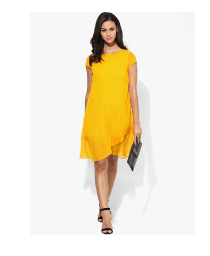

In [147]:
outputs = []
dominants = []

images = sorted(glob('sample/medium/*'))
img = cv2.imread(images[12], cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = background_mask(img)
tot = len(img[np.where(mask>0)])

for counter, (lower, upper) in enumerate(palette.boundaries):
    col_mask = cv2.inRange(img, lower, upper)
    col_mask = cv2.bitwise_and(mask, col_mask)
    area = len(img[np.where(col_mask>0)])
    outputs.append(cv2.bitwise_and(img, img, mask = col_mask))
    dominants.append((float(area)*100/tot, counter, palette.names[counter]))

print(sorted(dominants, reverse=True)[:10])
imshow(img)

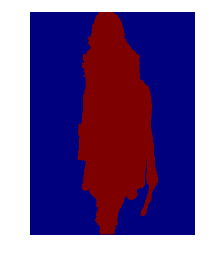

In [145]:
imshow(mask)